# Setup

Load data and imports.

In [1]:
import sys

sys.path.append('../')

Imports

In [2]:
import grantminer.w2v as w2v
import grantminer.data as data
import grantminer.config as config
import grantminer.plotting as plot
from gensim.models import KeyedVectors
import pickle
from importlib import reload

import numpy as np
import pandas as pd

/Users/akulesa/Desktop/Computational_Sourcing/NIH_RePORTER/envs/lib/python3.8/site-packages/gensim/similarities/__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


Spacy en_core_web_sm loaded!


### Datasets and Models

We have the following datasets and models now. 
1. `nih_grants` is pandas DataFrame that contains all the NIH grant data. Notable columns are `PROJECT_TITLE`, `PROJECT_TERMS`, `ORG_NAME`, `PI_NAMEs`, `TOTAL_COST`, `ABSTRACT_TEXT`

2. `word_vectors` is a gensim.models KeyedVectors instance for words identified in the cleaned and lemmatized abstracts. The keys are words. The vectors are (300,) vectors output by word2vec. 

3. `grant_vectors` is a gensim.models KeyedVectors instance with vectors assigned to each grant. This is calculated by averaging the vectors for each word in a the corresponding abstract. Keys are the index column in `nih_grants` DataFrame.



In [3]:
# NIH grants DataFrame
nih_grants = pd.read_csv(str(config.filepath['clean'] / 'NIH_grants.csv'),index_col=0)
abstracts = pd.concat([data.load(y,abstract=True) for y in [2018, 2019, 2020]])
nih_grants = nih_grants.merge(abstracts[['APPLICATION_ID','ABSTRACT_TEXT']],on='APPLICATION_ID')

# Word vector keys are words
word_vectors = w2v.load(model='vectors')

# Grant vector keys correspond to indices of NIH Grants DF
grant_vectors = KeyedVectors.load(str(config.model_dir / 'grant_vectors.pkl'))

/Users/akulesa/Desktop/Computational_Sourcing/NIH_RePORTER/envs/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (18) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [ ]:
# Getting a lot of duplicates later on, so de-duplicate here
# nih_grants_dedup = nih_grants.drop_duplicates(subset=['PROJECT_TITLE'])
# grant_vectors_dedup = KeyedVectors(300)
# grant_vectors_dedup.add_vectors(list(nih_grants_dedup.index),grant_vectors.vectors[~nih_grants.duplicated(subset=['PROJECT_TITLE']),:])

In [ ]:
# nih_grants_dedup.to_csv(str(config.filepath['clean'] / 'NIH_grants_dedup.csv'))
# grant_vectors_dedup.save(str(config.model_dir / 'grant_vectors_dedup.pkl'))

In [4]:
nih_grants_dedup = pd.read_csv(str(config.filepath['clean'] / 'NIH_grants_dedup.csv'),index_col=0)
grant_vectors_dedup = KeyedVectors.load(str(config.model_dir / 'grant_vectors_dedup.pkl'))

/Users/akulesa/Desktop/Computational_Sourcing/NIH_RePORTER/envs/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (18) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


### Quick Reference for KeyedVector objects

Full reference: https://radimrehurek.com/gensim/models/keyedvectors.html   

KeyedVector objects have many useful functions built in. I originally thought I had to do it myself. Listing the valuable ones here: 

- `.key_to_index()` maps a word to an index in the vector set. Also useful for seeing list of all words in vocab. 
- `.index_to_key()` maps index of vector to the matching key. 
- `[key]` returns the vector. 
- `similar_by_vector(vector,topn)` returns the topn most similar keys. If used with `word_vectors` returns similar words. If used with `grant_vectors` returns similar grants. 
- `similar_by_key(key,topn)` returns the topn most similar keys. If used with `word_vectors` returns similar words. If used with `grant_vectors` returns similar grants. 
- `wmdistance(document1, document2, norm=True)` computes the Word Mover’s Distance between two documents. This is slower than using grant_vectors but can also be used to compare similarity of two abstracts' keys in word_vectors. 
- `.rank(key1,key2)` ranks the distance from key2 to key1 in relation to the distance of all keys to key1. 
- `rank_by_centrality(words, use_norm=True)` ranks
- `.vectors` just the vectors.

The classic king - man + woman = queen:   
- `.most_similar(positive=['woman', 'king'], negative=['man'])`
- `.most_similar_cosmul(positive=['woman', 'king'], negative=['man'])`


## Simple explorations

### Word associations

In [219]:
word_vectors.most_similar(positive=['multiple_sclerosis','skin'],negative=['brain'])

[('autoimmune_disease', 0.5378227829933167),
 ('autoimmune', 0.5118712186813354),
 ('vulgaris', 0.4994119703769684),
 ('vitiligo', 0.4769000709056854),
 ('cutaneous', 0.4667735695838928),
 ('atopic_dermatitis', 0.46209368109703064),
 ('blister', 0.45936161279678345),
 ('rheumatoid_arthritis', 0.45686203241348267),
 ('mucocutaneous', 0.44098567962646484),
 ('nonmelanoma', 0.4405176639556885)]

In [220]:
word_vectors.most_similar_cosmul(positive=['multiple_sclerosis','mouse'],negative=['human'])

[('experimental_autoimmune', 0.8562911152839661),
 ('cuprizone', 0.8335213661193848),
 ('demyelinating', 0.8100724816322327),
 ('eae', 0.8100408315658569),
 ('encephalomyelitis_eae', 0.8098502159118652),
 ('demyelinate_disease', 0.8087018728256226),
 ('gliosis', 0.8050937056541443),
 ('mrl_lpr', 0.8000690937042236),
 ('mog', 0.7935073375701904),
 ('jhmv', 0.7909315824508667)]

### Find similar grants

In [222]:
def query_grant(selected,gv):

    print('Project Title: \n')
    print(nih_grants_dedup.loc[selected,'PROJECT_TITLE'])
    print('\n')
    print('Abstract: \n')
    print(nih_grants_dedup.loc[selected,'ABSTRACT_TEXT'])
    print('\n')

    print('Most similar word vectors:')

    for a,b in word_vectors.similar_by_vector(gv[selected]):
        print(a+ ', {}'.format(b))

    print('\n')
    print ('Most similar grants: ')
    for item in gv.most_similar(positive=selected,topn=10):
        print(str(item[0])+' '+nih_grants_dedup.loc[item[0],'PROJECT_TITLE']+', {}'.format(item[1]))

In [223]:
query_grant(50000,grant_vectors_dedup)

Project Title: 

Develop novel therapeutic strategy for brain tumor


Abstract: 

Mutations in isocitrate dehydrogenase (IDH1/2) are common genetic abnormalities in grade II and III diffusive astrocytomas and oligodendrogliomas. In WHO grade II/III gliomas, IDH mutated tumors are highly prevalent comprising nearly 80% of all clinical cases. In glioma, IDH mutations cluster in an arginine residue at the center of the catalytic domain (IDH1 R132, IDH2 R172). Mutant IDH confers neomorphic enzymatic activity that, catalyzes alpha-ketoglutarate (alpha-KG) into 2-hydroxyglutarate (2-HG), an oncometabolite closely related to the deactivation of alpha-KG-dependent deoxygenases. For example, IDH1 mutant derived 2-HG promotes hypoxia signaling by perturbing the catalytic activity of prolyl hydroxylase, resulting in constitutive activation of hypoxia-inducible factor 1alpha (HIF-1alpha). Additionally, 2-HG has also been found to affect collagen maturation and basement membrane function, which may

In [ ]:
query_grant(23323,grant_vectors_dedup)

In [ ]:
query_grant(40764,grant_vectors_dedup)

## Clustering

Try spectral clustering of grant vectors. 

In [5]:
from sklearn.cluster import SpectralClustering 

In [165]:
np.random.seed(42)
rndperm = np.random.permutation(nih_grants_dedup.shape[0])

subset = 20000

g = nih_grants_dedup.iloc[rndperm[:subset]][['APPLICATION_ID','PROJECT_TITLE']]
v = grant_vectors_dedup.vectors[rndperm[:subset],:]



In [ ]:
clustering = SpectralClustering(n_clusters=150, assign_labels='discretize', random_state=0).fit(v)

In [19]:
g['cluster'] = clustering.labels_
grants = g.merge(nih_grants_dedup[['APPLICATION_ID','clean','ABSTRACT_TEXT']],on='APPLICATION_ID')
grants.to_csv(str(config.filepath['clean'] / 'clustered.csv'))

In [173]:
cluster_keywords = []
for i in range(150):
    keywords = ' '.join([a for a,b in word_vectors.similar_by_vector(v[grants['cluster']==i,:].mean(axis=0))])
    cluster_keywords.append(keywords)

In [214]:
for i, row in grants[grants['cluster']==12].iterrows():
    print(row['PROJECT_TITLE']+'\n')

Understanding Oral Anticancer Medication Adherence among Patients with Multiple Myeloma

Testing a Medication Risk Communication and Surveillance Strategy: The EMC2 Trial

IMPROVE SAFETY, QUALITY AND EFFICIENCY IN RADIOTHERAPY WITH AUTOMATED HIT SYSTEM

Prediction of therapist cultural competency using Natural Language Processing (NLP) models

Administrative Supplement to Primary Palliative Care for Emergency Medicine

Nurse and Physician Decision-making for Suspected Urinary Tract Infections in Nursing Homes:  Potential Targets to Reduce Antibiotic Overuse

Fostering medication adherence in children with epilepsy using mHealth technology

Using Computational Approaches to Optimize Asthma Care Management

The Breathewell Program to Improve Asthma Outcomes

Ambulatory Pediatric Safety Learning Lab

Undersstanding Hospitals responsse to Mandatory shared Decision Making

The Family Input for Quality and Safety (FIQS) Study

Piloting a Patient-Reported Outcome Measure for Opioid Use Disord

In [61]:
centroids = np.asarray([v[grants['cluster']==i,:].mean(axis=0) for i in range(150)])
centroids = centroids/((centroids**2).sum(axis=1)**0.5).reshape(150,1)

In [66]:
from sklearn.metrics.pairwise import cosine_similarity

In [80]:
all_clusters = (cosine_similarity(grant_vectors_dedup.vectors[rndperm[subset:],:],centroids)).argmax(axis=1)

In [111]:
nih_grants_dedup = nih_grants_dedup.iloc[rndperm]

In [112]:
nih_grants_dedup['cluster'] = np.hstack((np.asarray(g['cluster']),all_clusters))

In [133]:
nih_grants_dedup = nih_grants_dedup.sort_index()

array([[<AxesSubplot:title={'center':'APPLICATION_ID'}>]], dtype=object)

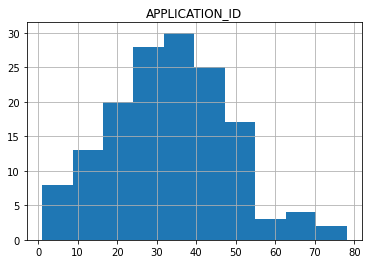

In [136]:
nih_grants_dedup.iloc[rndperm[:5000]].groupby('cluster').count().hist('APPLICATION_ID')

In [181]:
nih_grants_dedup['cluster_keywords']=[cluster_keywords[i] for i in nih_grants_dedup['cluster']]

In [182]:
nih_grants_dedup.to_csv(str(config.filepath['clean'] / 'NIH_grants_dedup.csv'))

## Plotting Explorations

### Imports

In [199]:
from bokeh.io import output_notebook, show
from bokeh.plotting import figure, gridplot
from bokeh.models import HoverTool
from bokeh.models import ColumnDataSource
from bokeh.palettes import brewer, Category10, Category20

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from bokeh.io import export_png

In [217]:
output_notebook()

Loading BokehJS ...

### Reduce dimensionality with PCA

tSNE has linear complexity in the number of dimensions, therefore, let's see if we can reduce the dimensionality with PCA first. 

Surprisingly, we can 90% of the variance with the first 150 components of PCA. This way it will run 2 times faster!

In [124]:
show(plot.pca_curve(grant_vectors_dedup.vectors))

In [137]:
# Reduces the dimensionality from 300 to 150 dimensions with PCA
grant_vectors_reduc = PCA(n_components=150).fit_transform(grant_vectors_dedup.vectors)

### tSNE visualizations

In [187]:
from itertools import product

Category150 = []
counter = 0
while counter < 150:
    Category150+=list(Category20[20])
    counter+=20

def apply_tsne(params,d,title,cluster=None,keywords=None):

    f = TSNE(n_components = 2,
             random_state = 0,
             **params)
    out = f.fit_transform(d)
    
    if cluster is None:
        cluster = 0
    
    if keywords is None:
        keywords = ''

    return pd.DataFrame(data=
                          dict(
                              title=title,
                              cluster=cluster,
                              keywords=keywords,
                              x = out[:,0],
                              y = out[:,1],
                              **params,
                          )
    ).reset_index()

def plot_tsne(df_in,plot_title):
    
#     l = max((len(df_in['cluster'].unique()),3))
    colors = Category150
    colormap = {i: colors[i] for i in df_in['cluster'].unique()}
    colors = [colormap[x] for x in df_in['cluster']]
    
    source = ColumnDataSource(dict(
        x=df_in['x'],
        y=df_in['y'],
        title=df_in['title'],
        cluster=df_in['cluster'],
        keywords=df_in['keywords'],
        colors=colors,
    ))

    hover = HoverTool(
        tooltips=[
            ("index", "$index"),
            ("title", "@title"),
            ("cluster", "@cluster"),
            ("cluster keywords","@keywords")
        ]
    )

    p = figure(
        plot_width=500, 
        plot_height=500,
        tools=['pan','wheel_zoom','box_zoom','reset',hover],
    )

    p.circle(x='x',y='y',color='colors',size=5,line_color=None,source=source,alpha=0.5)
    p.text(x=df_in['x'].min(),y=df_in['y'].min(),text=[plot_title],text_font_size=[10])
    return p

def format_title(param):
    s = ''
    for key, value in param.items():
        s += '{}:'.format(key)+' {}'.format(value)+'\n'
    return s

def select(df,**param):
    s = df.columns[0]==df.columns[0]
    for key, value in param.items():
        s = s & (df[key]==value)
    return df[s]

def tsne_scan(param_set,data,titles):
    all_tsne = pd.concat([apply_tsne(param, data, titles) for param in param_set]) \
        .reset_index() 
    
    grid = []

    for param in param_set:
        grid.append(
            plot_tsne(
                select(all_tsne,**param),
                format_title(param),
            )
        )

    return gridplot([grid]), all_tsne

def create_param_set(**kw_args):
    it = product(*tuple(kw_args.values()))
    return [dict(zip(kw_args.keys(),item)) for item in it]

In [191]:
np.random.seed(42)
rndperm = np.random.permutation(nih_grants_dedup.shape[0])

subset = 20000

g = nih_grants_dedup.iloc[rndperm[:subset]][['APPLICATION_ID','PROJECT_TITLE']]
v = grant_vectors_reduc[rndperm[:subset],:]
c = nih_grants_dedup.iloc[rndperm[:subset]]['cluster']
k = nih_grants_dedup.iloc[rndperm[:subset]]['cluster_keywords']

In [192]:
param_set = dict(perplexity=100,n_iter=2000,learning_rate=400)

In [193]:
df = apply_tsne(param_set,v,g['PROJECT_TITLE'],cluster=c,keywords=k)
fig = plot_tsne(df,'')


In [218]:
show(fig)

In [198]:
export_png(fig, filename="NIH Grants 20000.png")

'/Users/akulesa/Desktop/Computational_Sourcing/NIH_RePORTER/notebooks/NIH Grants 20000.png'

In [216]:
df.to_csv('tSNE of NIH Grants 20000.csv')